# Modelling coupled degradation mechanisms in PyBaMM

This notebook shows how to set up a PyBaMM model in which many degradation mechanisms run at the same time and interact with one another.

0714 change positive concentration ["Initial concentration in positive electrode [mol.m-3]"] = 12800
param["Outer SEI solvent diffusivity [m2.s-1]"] = 7E-21


In [234]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import pybamm
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


O'Kane et al. [10] modelled four coupled degradation mechanisms: SEI growth, lithium plating, particle cracking and stress-driven loss of active material. The "SEI on cracks" option couples SEI growth and particle cracking by allowing SEI to grow on the cracks. The "partially reversible" option for lithium plating allows the SEI to influence the irreversible component of plating using a function in the OKane2022 parameter file. Particle cracking and stress-driven loss of active material are coupled by default because the stress-strain relations inside the particles are an input for both.

In [235]:
model = pybamm.lithium_ion.DFN(
    {
        "SEI": "solvent-diffusion limited",
        "SEI porosity change": "true",
        "lithium plating": "partially reversible",
        "lithium plating porosity change": "true",  # alias for "SEI porosity change"
        "particle mechanics": ("swelling and cracking", "swelling only"),
        #"particle mechanics": "swelling and cracking",
        "SEI on cracks": "true",
        "loss of active material": "stress-driven",
        "calculate discharge energy": "true",  # for compatibility with older PyBaMM versions
        "thermal": "lumped", 
    }
)

Depending on the parameter set being used, the particle cracking model can require a large number of mesh points inside the particles to be numerically stable.

In [236]:
param = pybamm.ParameterValues("OKane2023_Xinlei")
var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator
    "x_p": 5,  # positive electrode
    "r_n": 30,  # negative particle
    "r_p": 30,  # positive particle
}

In [237]:
print(param["Negative electrode partial molar volume [m3.mol-1]"])
print(param["Negative electrode critical stress [Pa]"])
param["Negative electrode critical stress [Pa]"] = 6e8
print(param["Negative electrode critical stress [Pa]"])

3.1e-06
60000000.0
600000000.0


In [238]:
print(param["Positive electrode partial molar volume [m3.mol-1]"])
print(param["Positive electrode critical stress [Pa]"])

7.88e-07
2000000000.0


In [239]:
print(param["Initial concentration in negative electrode [mol.m-3]"])
param["Initial concentration in negative electrode [mol.m-3]"] = 28600
print(param["Initial concentration in negative electrode [mol.m-3]"])

28800
28600


In [240]:


print(param["Initial concentration in positive electrode [mol.m-3]"])
param["Initial concentration in positive electrode [mol.m-3]"] = 12800
print(param["Initial concentration in positive electrode [mol.m-3]"])

12729.0
12900


In [241]:
print(param["Outer SEI solvent diffusivity [m2.s-1]"])
print(param["Positive outer SEI solvent diffusivity [m2.s-1]"])
print(param["Negative outer SEI solvent diffusivity [m2.s-1]"])

D_sol = 7e-21
param["Outer SEI solvent diffusivity [m2.s-1]"] = D_sol
param["Positive outer SEI solvent diffusivity [m2.s-1]"] = D_sol
param["Negative outer SEI solvent diffusivity [m2.s-1]"] = D_sol

print(param["Outer SEI solvent diffusivity [m2.s-1]"])
print(param["Positive outer SEI solvent diffusivity [m2.s-1]"])
print(param["Negative outer SEI solvent diffusivity [m2.s-1]"])

2.5000000000000002e-22
2.5000000000000002e-22
2.5000000000000002e-22
7e-21
7e-21
7e-21


Define a cycling protocol and solve. The protocol from O'Kane et al. [10] is used here, except with 10 ageing cycles instead of 1000.

In [242]:
cycle_number = 20
exp = pybamm.Experiment(
    # [
    #     "Hold at 4.2 V until C/100 (5 minute period)",
    #     "Rest for 4 hours (5 minute period)",
    #     "Discharge at 0.1C until 2.5 V (5 minute period)",  # initial capacity check
    #     "Charge at 1C until 4.2 V (5 minute period)",
    #     "Hold at 4.2 V until C/100 (5 minute period)",
    # ]
    # + 
    [
        (
            "Charge at C/3 until 4.2 V",
            "Hold at 4.2 V until C/20",
            "Discharge at 1C until 2.5 V",  # ageing cycles
            #"Discharge at 1C until 2.5 V"

        )
    ]
    * cycle_number
    #+ ["Discharge at 0.1C until 2.5 V (5 minute period)"],  # final capacity check
)
sim = pybamm.Simulation(model, parameter_values=param, experiment=exp, var_pts=var_pts)
sol = sim.solve(initial_soc=0)

At t = 108.527 and h = 1.01163e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 108.527 and h = 1.27871e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 108.527 and h = 1.31616e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 48.5272 and h = 1.67391e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 103.284 and h = 8.90247e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 103.284 and h = 1.49838e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 103.284 and h = 8.18888e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 99.0316 and h = 1.944e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 99.0311 and h = 5.27934e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 99.0319 and h = 5.21011e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At

In [ ]:
def calculate_capacities(sol):
    # 初始化充电容量和放电容量列表
    charge_capacities = []
    discharge_capacities = []

    # 遍历sol数据结构中的每个循环
    for cycle in sol.cycles:
        # 获取第一个步骤的放电容量时间序列
        step1_times = cycle.steps[0]["Discharge capacity [A.h]"].entries
        # 获取第二个步骤的放电容量时间序列
        step2_times = cycle.steps[1]["Discharge capacity [A.h]"].entries
        # 获取第三个步骤的放电容量时间序列
        step3_times = cycle.steps[2]["Discharge capacity [A.h]"].entries

        # 计算第一个步骤的初始值和第二个步骤的最后值的差（充电容量）
        charge_capacity = step2_times[-1] - step1_times[0]
        charge_capacities.append((-1) * charge_capacity)
        
        # 计算第三步的初始值和最后值的差（放电容量）
        discharge_capacity = step3_times[-1] - step3_times[0]
        discharge_capacities.append(discharge_capacity)

    # 返回计算结果
    return charge_capacities, discharge_capacities

# 假设 sol 已定义并包含需要的数据
# 调用函数并接收结果
charge_capacities, discharge_capacities = calculate_capacities(sol)

# 输出结果
print("充电容量:", charge_capacities)
print("放电容量:", discharge_capacities)




充电容量: [4.978590566800544, 4.655071039619312, 4.647745194599502, 4.641775216825434, 4.6365410089915775, 4.631789608779137, 4.627357425230359, 4.623205318409907, 4.619268259175187, 4.615499268946538, 4.611870988654727, 4.608360340660285, 4.604948938635275, 4.601623949502345, 4.598373091960087, 4.595186015112246, 4.592054776573906, 4.5889722205650765, 4.5859313756908096, 4.582927326150206]
放电容量: [4.655343975035136, 4.647964007495576, 4.641968236138883, 4.636719001870188, 4.6319580929506, 4.62751990193713, 4.623363498804892, 4.619423560676528, 4.615652200863489, 4.6120220149667555, 4.608509826460733, 4.605097306945035, 4.601771856676955, 4.598520733027494, 4.595333809245207, 4.592203313568244, 4.589121762155486, 4.586082199907733, 4.5830798219536435, 4.5801108319547295]


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
cwd = os.getcwd()


# 读取 pickle 文件
#pickle_file_path = cwd + '/docs/source/examples/notebooks/models/exp_LG/processed_data.pkl'
pickle_file_path = cwd + '/exp_LG/processed_data.pkl'
cycles_df = pd.read_pickle(pickle_file_path)
print("DataFrame loaded from pickle file")
print(cycles_df.head())


# 提取每个循环的最后一个 Q_dis 和 Q_cha 非零值
summary_data = []

for cycle in cycles_df.index.levels[0]:
    cycle_data = cycles_df.loc[cycle]
    last_q_dis = cycle_data[cycle_data['Q_dis'] > 0]['Q_dis'].iloc[-1] if not cycle_data[cycle_data['Q_dis'] > 0].empty else 0
    last_q_cha = cycle_data[cycle_data['Q_cha'] > 0]['Q_cha'].iloc[-1] if not cycle_data[cycle_data['Q_cha'] > 0].empty else 0
    summary_data.append([cycle, last_q_cha, last_q_dis])

# 创建一个新的 DataFrame 存储结果
summary_df = pd.DataFrame(summary_data, columns=['Cycle', 'Last_Q_cha', 'Last_Q_dis'])

DataFrame loaded from pickle file
            Mode  RelativeTime   Voltage          I  Q_dis     Q_cha  \
Cycle Step                                                             
1     1      1.0        0.0000  2.680430  1407.8055    0.0  0.000078   
      2      1.0        0.0084  2.690530  1574.4427    0.0  0.003691   
      3      1.0        0.0294  2.700598  1640.2499    0.0  0.013108   
      4      1.0        0.0634  2.710643  1664.4644    0.0  0.028749   
      5      1.0        0.1074  2.720645  1668.5892    0.0  0.049123   

                 Cap         R    Pressure  Temperature  
Cycle Step                                               
1     1     0.000078  1.903978  159.026607      25.3794  
      2     0.003691  1.708878  158.944819      25.3885  
      3     0.013108  1.646455  158.998347      25.4014  
      4     0.028749  1.628537  159.049016      25.4088  
      5     0.049123  1.630506  158.990980      25.4014  


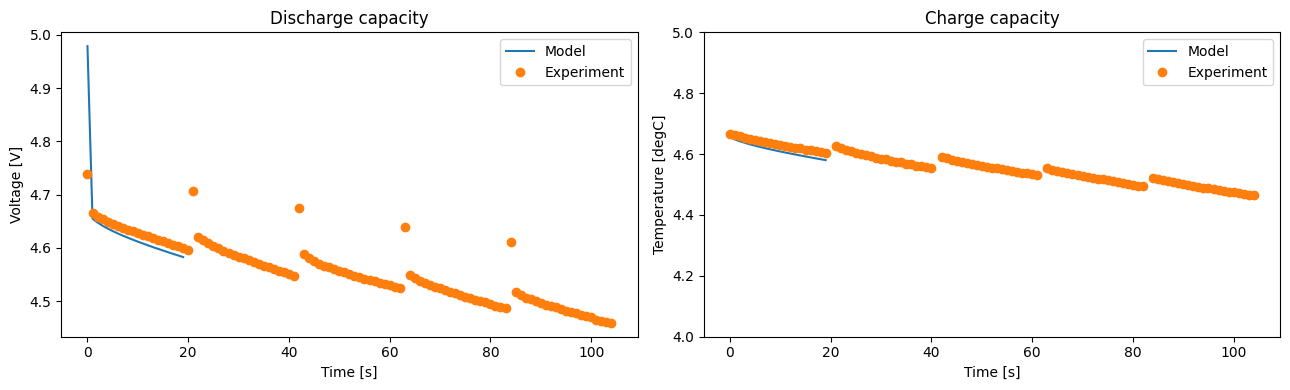

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C results
t_sol = sol["Time [s]"].entries

ax1.plot(charge_capacities)
ax1.plot(summary_df["Last_Q_cha"]/1000, "o")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("Discharge capacity")
ax1.legend(["Model", "Experiment"], loc="best")

ax2.plot(discharge_capacities)
ax2.plot(summary_df["Last_Q_dis"]/1000, "o")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Temperature [degC]")
ax2.set_title("Charge capacity")
ax2.set_ylim(4,5)
ax2.legend(["Model", "Experiment"], loc="best")

plt.tight_layout()
plt.show()

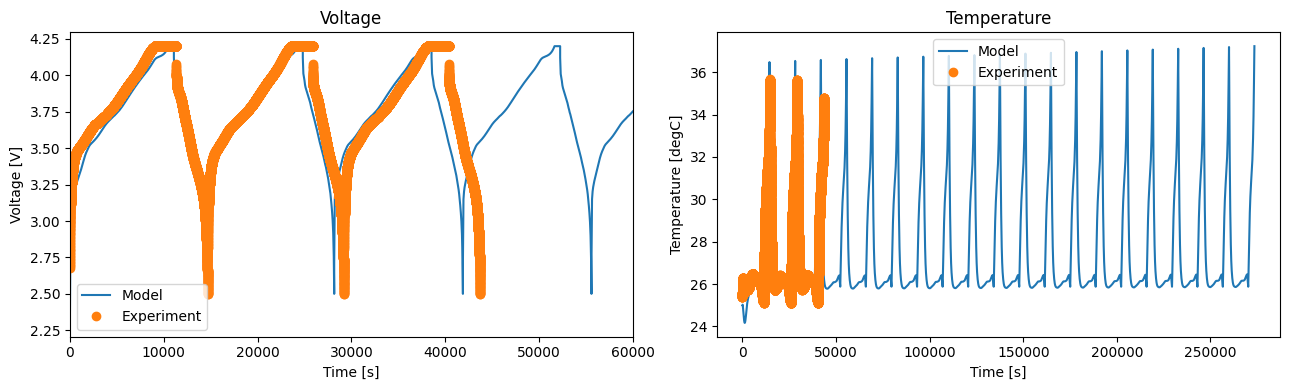

In [ ]:
# Merge the first two cycles for Voltage and Temperature
merged_cycles_voltage = pd.concat([cycles_df.loc[1]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1],
                                   cycles_df.loc[2]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1],
                                   cycles_df.loc[3]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1]])
merged_voltage = pd.concat([cycles_df.loc[1]["Voltage"], cycles_df.loc[2]["Voltage"],cycles_df.loc[3]["Voltage"]])

merged_cycles_temperature = pd.concat([cycles_df.loc[1]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1], 
                                       cycles_df.loc[2]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1],
                                       cycles_df.loc[3]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1]])
merged_temperature = pd.concat([cycles_df.loc[1]["Temperature"], cycles_df.loc[2]["Temperature"], cycles_df.loc[3]["Temperature"]])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C results
#t_sol_nodeg = sol_nodeg_breakin["Time [s]"].entries

ax1.plot(t_sol, sol["Voltage [V]"](t_sol))
ax1.plot(merged_cycles_voltage, merged_voltage, "o")
ax1.set_xlim(0,6e4)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("Voltage")
ax1.legend(["Model", "Experiment"], loc="best")

#ax2.plot(t_sol_nodeg, sol_nodeg_breakin["X-averaged cell temperature [C]"](t_sol_nodeg))
ax2.plot(t_sol, sol["X-averaged cell temperature [C]"](t_sol))
ax2.plot(merged_cycles_temperature, merged_temperature, "o")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Temperature [degC]")
ax2.set_title("Temperature")
ax2.legend(["Model", "Experiment"], loc="best")

plt.tight_layout()
plt.show()

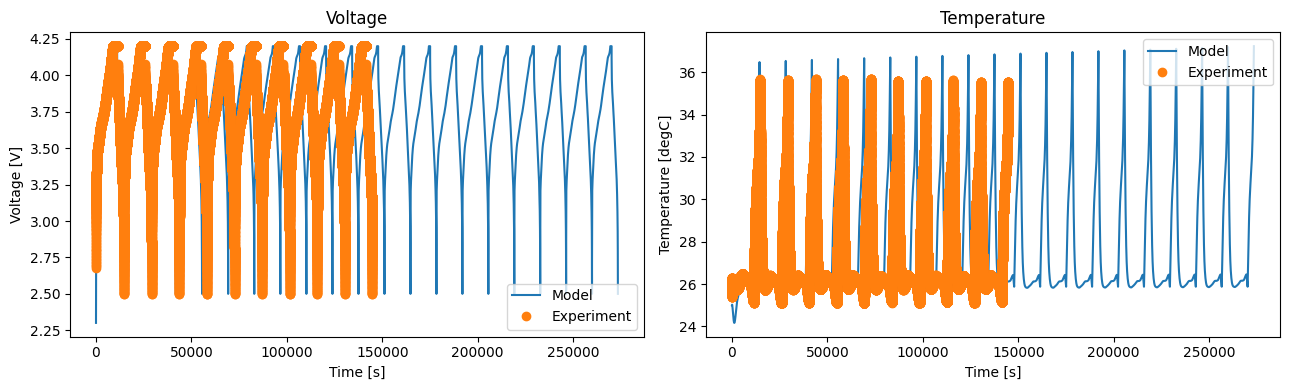

In [ ]:
# 假设 `cycles_df` 是一个字典，其中的键是循环编号，每个键对应的值是包含该循环数据的DataFrame。

# 初始化空的DataFrame来存储合并后的电压和温度数据
merged_voltage = pd.DataFrame()
merged_temperature = pd.DataFrame()

# 初始化空的DataFrame来存储合并后的相对时间
merged_cycles_time = pd.DataFrame()

# 基准时间，从第一个循环的第一个数据点开始
base_time = cycles_df.loc[1]["RelativeTime"].iloc[0]

# 合并前20个循环
for i in range(1, 11):
    # 调整时间以基于第一个循环的起始时间
    adjusted_time = cycles_df.loc[i]["RelativeTime"] - base_time
    
    # 将调整后的时间添加到时间DataFrame中
    merged_cycles_time = pd.concat([merged_cycles_time, adjusted_time], ignore_index=True)
    
    # 将电压数据添加到电压DataFrame中
    merged_voltage = pd.concat([merged_voltage, cycles_df.loc[i]["Voltage"]], ignore_index=True)
    
    # 将温度数据添加到温度DataFrame中
    merged_temperature = pd.concat([merged_temperature, cycles_df.loc[i]["Temperature"]], ignore_index=True)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C results
t_sol = sol["Time [s]"].entries

ax1.plot(t_sol, sol["Voltage [V]"](t_sol))
ax1.plot(merged_cycles_time, merged_voltage, "o")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("Voltage")
ax1.legend(["Model", "Experiment"], loc="best")

ax2.plot(t_sol, sol["X-averaged cell temperature [C]"](t_sol))
ax2.plot(merged_cycles_time, merged_temperature, "o")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Temperature [degC]")
ax2.set_title("Temperature")
ax2.legend(["Model", "Experiment"], loc="best")

plt.tight_layout()
plt.show()

Three of the degradation mechanisms - SEI, lithium plating and SEI on cracks - cause loss of lithium inventory (LLI). Plotting the different contributions to LLI against throughput capacity as opposed to cycle number allows them to be considered as continuous variables as opposed to discrete ones.

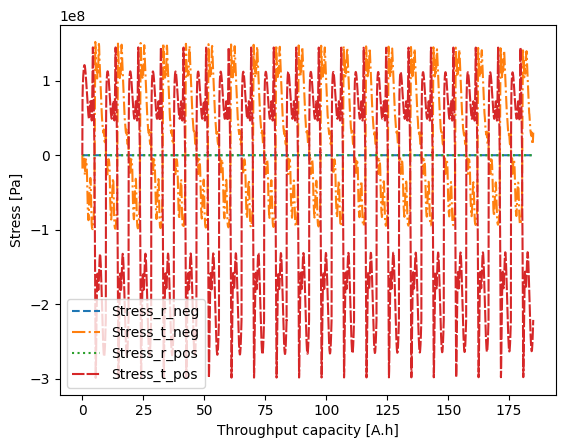

In [ ]:


Qt = sol["Throughput capacity [A.h]"].entries
Stress_r_neg = sol["X-averaged negative particle surface radial stress [Pa]"].entries
Stress_t_neg = sol["X-averaged negative particle surface tangential stress [Pa]"].entries
Stress_r_pos = sol["X-averaged positive particle surface radial stress [Pa]"].entries
Stress_t_pos = sol["X-averaged positive particle surface tangential stress [Pa]"].entries
plt.figure()
plt.plot(Qt, Stress_r_neg, label="Stress_r_neg", linestyle="dashed")
plt.plot(Qt, Stress_t_neg, label="Stress_t_neg", linestyle="dashdot")
plt.plot(Qt, Stress_r_pos, label="Stress_r_pos", linestyle="dotted")
plt.plot(Qt, Stress_t_pos, label="Stress_t_pos", linestyle=(0, (6, 1)))

plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Stress [Pa]")
plt.legend()
plt.show()


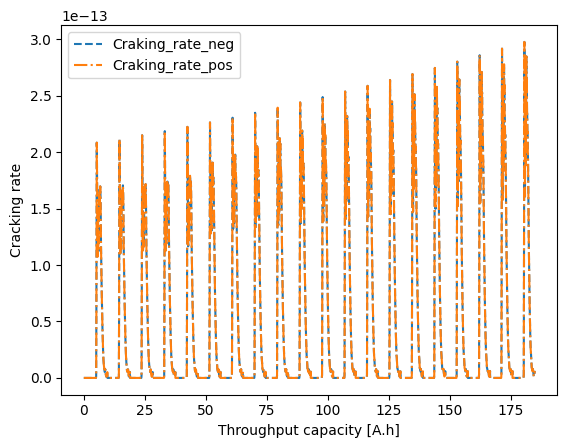

In [ ]:
Qt = sol["Throughput capacity [A.h]"].entries
Craking_rate_neg = sol["X-averaged negative particle cracking rate [m.s-1]"].entries
Craking_rate_pos = sol["X-averaged negative particle cracking rate [m.s-1]"].entries
plt.figure()
plt.plot(Qt, Craking_rate_neg, label="Craking_rate_neg", linestyle="dashed")
plt.plot(Qt, Craking_rate_pos, label="Craking_rate_pos", linestyle="dashdot")


plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Cracking rate")
plt.legend()
plt.show()

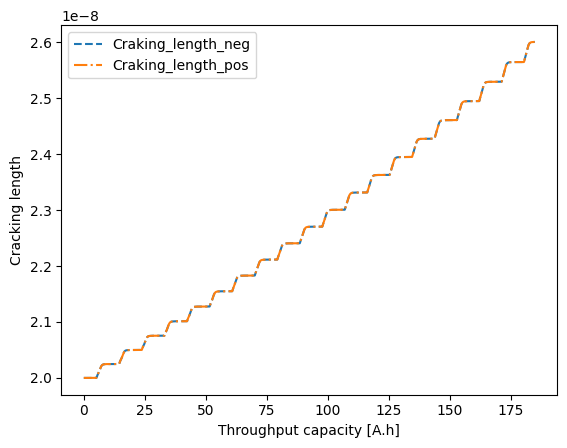

In [ ]:
Qt = sol["Throughput capacity [A.h]"].entries
Craking_rate_neg = sol["X-averaged negative particle crack length [m]"].entries
Craking_rate_pos = sol["X-averaged negative particle crack length [m]"].entries
plt.figure()
plt.plot(Qt, Craking_rate_neg, label="Craking_length_neg", linestyle="dashed")
plt.plot(Qt, Craking_rate_pos, label="Craking_length_pos", linestyle="dashdot")


plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Cracking length")
plt.legend()
plt.show()

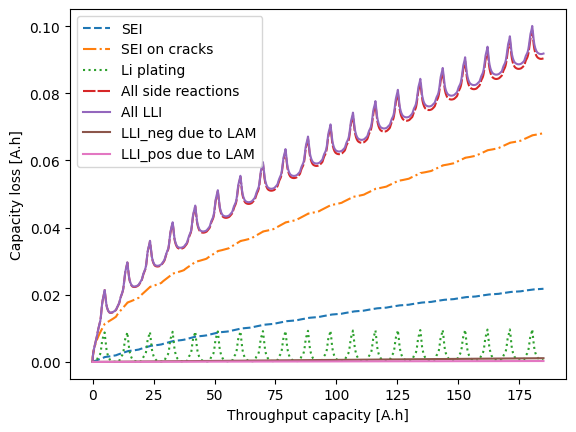

In [ ]:
Qt = sol["Throughput capacity [A.h]"].entries
Q_SEI = sol["Loss of capacity to negative SEI [A.h]"].entries
Q_SEI_cr = sol["Loss of capacity to negative SEI on cracks [A.h]"].entries
Q_plating = sol["Loss of capacity to negative lithium plating [A.h]"].entries
Q_side = sol["Total capacity lost to side reactions [A.h]"].entries
Q_LLI = (
    sol["Total lithium lost [mol]"].entries * 96485.3 / 3600
)  # convert from mol to A.h

Q_LLI_due2_LAM_neg = (
    sol["Loss of lithium due to loss of active material in negative electrode [mol]"].entries * 96485.3 / 3600
)
Q_LLI_due2_LAM_pos = (
    sol["Loss of lithium due to loss of active material in positive electrode [mol]"].entries * 96485.3 / 3600
)
plt.figure()
plt.plot(Qt, Q_SEI, label="SEI", linestyle="dashed")
plt.plot(Qt, Q_SEI_cr, label="SEI on cracks", linestyle="dashdot")
plt.plot(Qt, Q_plating, label="Li plating", linestyle="dotted")
plt.plot(Qt, Q_side, label="All side reactions", linestyle=(0, (6, 1)))
plt.plot(Qt, Q_LLI, label="All LLI")
plt.plot(Qt, Q_LLI_due2_LAM_neg, label="LLI_neg due to LAM")
plt.plot(Qt, Q_LLI_due2_LAM_pos, label="LLI_pos due to LAM")
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Capacity loss [A.h]")
plt.legend()
plt.show()

The capacity loss over 10 cycles is so small that the reversible component of the lithium plating is has a larger effect than all the irreversible mechanisms combined. Most of the irreversible capacity fade that does occur is caused by SEI on cracks.

The stress-driven loss of active material (LAM) mechanism [10,11] is also included, so the three main degradation modes - LLI and LAM in each electrode - can be plotted and compared.

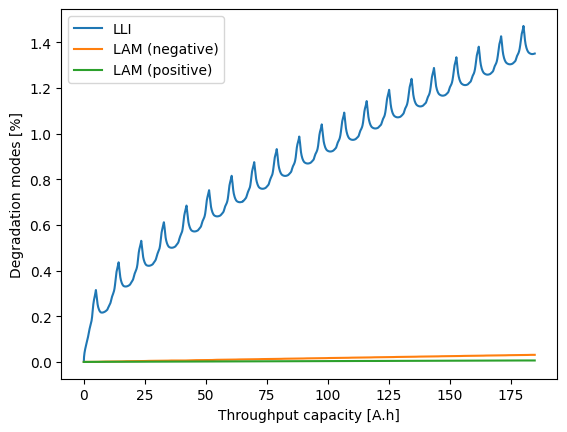

In [ ]:
Qt = sol["Throughput capacity [A.h]"].entries
LLI = sol["Loss of lithium inventory [%]"].entries
LAM_neg = sol["Loss of active material in negative electrode [%]"].entries
LAM_pos = sol["Loss of active material in positive electrode [%]"].entries
plt.figure()
plt.plot(Qt, LLI, label="LLI")
plt.plot(Qt, LAM_neg, label="LAM (negative)")
plt.plot(Qt, LAM_pos, label="LAM (positive)")
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Degradation modes [%]")
plt.legend()
plt.show()

Both the reversible and irreversible components of LLI are far greater than LAM for this parameter set.

A key internal variable is the porosity. Pore clogging by SEI, lithium plating and other means can trigger other degradation mechanisms and reduce the rate capability of the cell. If the porosity reaches zero, the cell becomes completely unusable and PyBaMM will terminate the simulation.

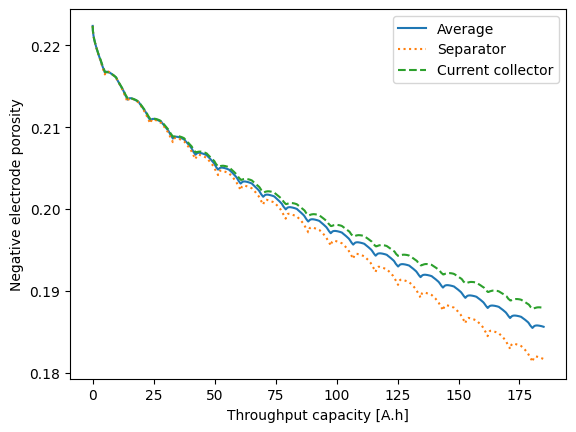

In [ ]:
eps_neg_avg = sol["X-averaged negative electrode porosity"].entries
eps_neg_sep = sol["Negative electrode porosity"].entries[-1, :]
eps_neg_CC = sol["Negative electrode porosity"].entries[0, :]
plt.figure()
plt.plot(Qt, eps_neg_avg, label="Average")
plt.plot(Qt, eps_neg_sep, label="Separator", linestyle="dotted")
plt.plot(Qt, eps_neg_CC, label="Current collector", linestyle="dashed")
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Negative electrode porosity")
plt.legend()
plt.show()

If you want to see some serious degradation, try re-running the simulation with more ageing cycles, or using param.update({}) to increase the degradation parameters beyond the ranges considered by O'Kane et al. [10]

In [ ]:
pybamm.print_citations()

[1] Weilong Ai, Ludwig Kraft, Johannes Sturm, Andreas Jossen, and Billy Wu. Electrochemical thermal-mechanical modelling of stress inhomogeneity in lithium-ion pouch cells. Journal of The Electrochemical Society, 167(1):013512, 2019. doi:10.1149/2.0122001JES.
[2] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[3] Von DAG Bruggeman. Berechnung verschiedener physikalischer konstanten von heterogenen substanzen. i. dielektrizitätskonstanten und leitfähigkeiten der mischkörper aus isotropen substanzen. Annalen der physik, 416(7):636–664, 1935.
[4] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical S